# Implementing and Practicing FNN and CNN on MNIST Dataset

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim 
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:

input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_dataset = datasets.MNIST(
    './data', 
    train=True,     # creates dataset subset from train-images-idx3-ubtye, not t10k-images-idx30ubyte
    download=True,  # downloads dataset from internet and puts it in root directory. If not already downloaded. 
    transform=transforms.Compose( # composes several transforms together
                # convert PIL or numpy.ndarray to tensor. 
                # From PIL (H, W, C) in range [0,255] to torch(C,H,W) in [0,1]
              [transforms.ToTensor(), 
                # normalize a tensor image with mean and std. 
                # Does not support PIL. 
                # transforms is out of place, must assign
                # param = (mean1, mean2...), (std1, std2,..) for n-channels
               transforms.Normalize((0.1307,), (0.3081,))])) 
                                      
train_loader = torch.utils.data.DataLoader(
    train_dataset,  # dataloader represents python iterable over a dataset
    batch_size=64,  # automatically collate individual fetched sampes into batches
    shuffle=True)   # have data reshuffled at every epoch (def = False)

test_dataset = datasets.MNIST(
    './data', 
    train=False, 
    transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
                             )
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True)

Previewing a single image from each of the 10 classes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


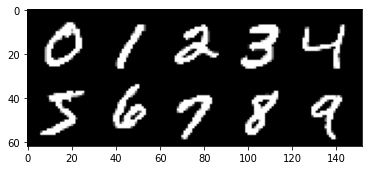

In [ ]:
# get 1 image from each class
c = [x for x in range(10)]
imgs = []
for img, label in train_dataset:
    if label in c:
        imgs.append((img, label))
        c.remove(label)
    if len(c) == 0:
        break

# sort images according to label
imgs = sorted(imgs, key = lambda x: x[1])
imgs = [x[0] for x in imgs]

# plot each image on a (2x5) grid
grid = torchvision.utils.make_grid(imgs, nrow=5)

# option 2 to display
plt.imshow(grid.permute(1,2,0)) # or pick this

FNN: Create a simple 3-layer FNN that takes in size 784, and outputs 1 of 10 classes. 

Hidden layer of size (8,8).

We'll use ReLU non-linearity with a LogSoftmax function for the final layer. 

The model will have an architecture of:
- linear_layer(input_size, n_hidden)
- relu
- linear_layer(n_hidden, n_hidden)
- relu
- linear_layer(n_hidden, output_size)
- log_softmax

In [ ]:
class FNN(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FNN, self).__init__()
        self.input_size = input_size
        self.n_hidden = n_hidden
        self.output_size = output_size
        self.flatten = nn.Flatten()
        
        self.linear_relu_flow = nn.Sequential(
            # (64, 784)(784, 8) = (64, 8) (8, 8) = (64, 8) (8, 10) = (64, 10)
            nn.Linear(self.input_size, self.n_hidden), # linear transformation
            nn.ReLU(), # applies rectified linear unit function element-wise
            nn.Linear(self.n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(self.n_hidden, self.output_size),      
            # dim - 0 is the batch dimension and gives the #samples in current batch, 
            # dim = 1 is the feature dimension and gives number of different features
            nn.LogSoftmax(dim=1)
            )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_flow(x) # send input through sequentially
        return logits

### Define train and test function

We'll define our loss function as cross entropy. 

Note:
- `permute` is a function passed as an argument to train and test functions.
- `permutation_order` is a 1D torch array of size 784 (=28*28). It contains the random order for permutating the pixels in the `28x28` images.

In [ ]:
def train(epoch, model, optimizer, permute_pixels = None, permutation_order = None):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(train_loader):

        # make sure all vars have the same device as model
        data, target = data.to(device), target.to(device)

        # permute the pixels if set
        if permute_pixels is not None:
            data = permute_pixels(data, permutation_order)
        
        # compute predict error
        output = model.forward(data) # model.forward(data) 
        loss = loss_fn(output, target)
        
        # back propagation
        optimizer.zero_grad()   # erase all gradients before computing new one
        loss.backward()         # compute gradients of params w.r.t. loss (chain rule)
        optimizer.step()        # update weights using gradients and learning rate
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    

            
def test(model, permute_pixels = None, permutation_order = None):
    model.eval()
    test_loss, correct = 0, 0
    loss_fn = nn.CrossEntropyLoss()

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        if permute_pixels is not None:
            data = permute_pixels(data, permutation_order)
        
        output = model.forward(data) 
        test_loss += loss_fn(output, target).item() 
        
        # torch.max(tensor) -> produces deterministic (sub) gradients
        # torch.argmax(tensor) returns indices of max values of a tensor across dim

        pred = output   # obtain index of the max log-probability       
        correct += (pred.argmax(1) == target).type(torch.float).sum().item()  
    
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))
    return accuracy

### Computing the total parameter count of the model

In [ ]:
# function to computing the total parameter count of the model
def get_n_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable only

### Train a small fully-connected network

In [ ]:
n_hidden = 8
model_fnn = FNN(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr = 0.01, momentum = 0.5) # use SGD with learning rate 0.01 and momentum 0.5
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

test_accuracy = []
for epoch in range(0, 1):
    train(epoch, model_fnn, optimizer)
    test_accuracy.append(test(model_fnn))

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.360872
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.834459
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.011341
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.524063
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.448661
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.414314
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.332942
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.446152
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.489850
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.325390

Test set: Average loss: 0.0004, Accuracy: 8881.0/10000 (89%)



### Convolutional Neural Network (CNN) on MNIST

We'll define a CNN with the following architecture:


Conv:
- conv2D(input_size, conv_feature, kernel_size=5)
- relu()
- maxpool2d(kernel_size=2)
- conv2d(conv_feature, conv_feature, kernel_size=5)
- relu()
- maxpool2d(kernel_size=2)


FC:
- linear_feature(conv_feature*4*4, fc_feature),
- relu(),
- linear_feature(fc_feature, output_size),
- log_softmax()



In [ ]:
class CNN(nn.Module):

    def __init__(self, input_size, conv_features, fc_features, output_size):
        super(CNN, self).__init__()
        self.input_size = input_size
        self.conv_features = conv_features
        self.fc_features = fc_features
        self.output_size = output_size
        self.flatten = nn.Flatten()

        self.conv_flow = nn.Sequential(
            # (in_channels = 1, out_channels = 6, kernel = 5)
            nn.Conv2d(1, self.conv_features, kernel_size = 5), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            # (in = 6 channels, out = 6 channels, kernep = 5)
            nn.Conv2d(self.conv_features, self.conv_features, kernel_size =5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
            )
        
        self.fc_flow = nn.Sequential(
            # recall (m x n)(n x k) = m x k
            # right now after conv = (64, 6, 4, 4)
            # input size = 96, output size = 50
            nn.Linear(self.conv_features*4*4, self.fc_features),
            nn.ReLU(),
            # linear shape (50, 10)
            nn.Linear(self.fc_features, self.output_size),
            nn.LogSoftmax(dim = 1)
            )
   
    def forward(self, x):
        # batch, channel, height, width       
        conv_res = self.conv_flow(x)
        logits = self.fc_flow(torch.reshape(conv_res, (x.shape[0], 96))) # 64, 96
        
        return logits

### Train a ConvNet with the same number of parameters

In [ ]:
input_size  = 28*28     # images are 28x28 pixels = 784
conv_features = 6       # number of feature maps
fc_features = 50
output_size = 10       

model_cnn = CNN(input_size, conv_features, fc_features, output_size) 
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr = 0.01, momentum = 0.5) 
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

test_accuracy = []
for epoch in range(0, 1):
    train(epoch, model_cnn, optimizer)
    test_accuracy.append(test(model_cnn))

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.328197
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.921420
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.783491
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.366673
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.169559
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.201823
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.193366
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.165167
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.116980
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.108496

Test set: Average loss: 0.0002, Accuracy: 9468.0/10000 (95%)



CNNs are more specific-purpose networks. It works off the assumption that the inputs are images, taking advantage of local spatial structures and adjacent pixels. Weight sharing by applying the same filter at all regions of an image allows better feature extraction, while max pooling reduces overfitting. This indicates that at every training iteration, CNNs should have a steeper decrease in loss than FNNs which is true by observation. 

On the other hand, FNNs generally has losses in spatial information since all output nodes are connected to all input nodes. And since FNN does not share weights, they are less equiped for feature extraction. Intuitively, then it makes sense that at during training, losses decrease much slower than CNNs. 

Also, FNNs are structure agnostic, so they are widely applicable, with no assumptions made on input. Likewise they tend to be weaker against specific-purpose networks like CNN. 

We can prove this by permuting the input images and testing again between FNN and CNN

In [ ]:
# Given a permutation order, permute the pixels of the input image
def permute_pixels(data, permutation_order):
    """
    Permute the pixels of the input image
    
    Args:
        data (torch tensor): batch of input images of shape (Batch, H, W) 
        permutation_order (1D torch array): order of the permutation
    
    Returns:
        permuted_data (torch tensor): permuted batch of input images of shape (B, 1, H, W)
    """
    # torch.stack(seq of tensors, dim) concats sequence of tensors
    # x.view(*shape) returns new tensor with the same data as slef but of different shape
    # x.view(-1) flattens the tensor if it wasn't already
    # x.view(-1) acceess those indexes and views them in permutation order for every image in data along batch dim.
    permuted_data = torch.stack([x.view(-1)[permutation_order].view(1,28,28) for x in data], dim = 0)
    return permuted_data

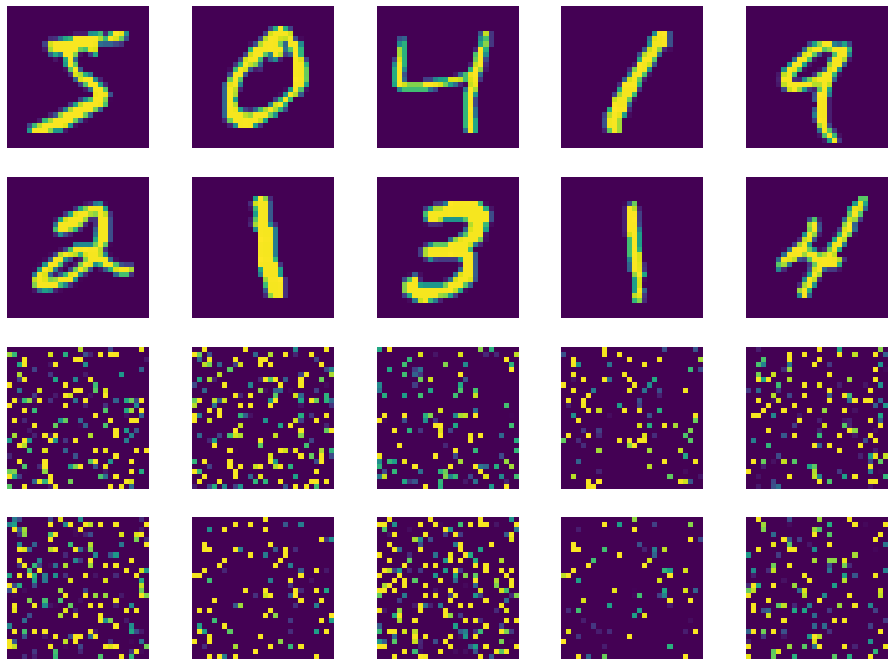

In [12]:
permutation_order = torch.randperm(28*28)

plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = permute_pixels(image.clone(), permutation_order)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

### CNN with permuted pixels


In [ ]:
conv_features = 6 # number of feature maps
fc_features = 50

model_cnn = CNN(input_size, conv_features, fc_features, output_size)  
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr = 0.01, momentum = 0.5) 
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, optimizer, permute_pixels, permutation_order)
    test(model_cnn, permute_pixels, permutation_order)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.351170
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.279015
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.250471
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.152046
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.712092
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.313443
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.841296
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.859609
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.797248
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.709577

Test set: Average loss: 0.0007, Accuracy: 7929.0/10000 (79%)



### FNN with Permuted Pixels

In [ ]:
n_hidden = 8    

model_fnn = FNN(input_size, n_hidden, output_size) 
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr = 0.01, momentum = 0.5) 
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, optimizer, permute_pixels)
    test(model_fnn, permute_pixels)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.321096
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.802657
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.046307
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.734225
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.617375
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.628350
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.609503
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.528814
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.478630
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.505369

Test set: Average loss: 0.0004, Accuracy: 8879.0/10000 (89%)



A comparison would be a jigsaw puzzle. A set of pieces that have can complete clear picture is easier to recognize or identify. 

On the other hand, a set of pieces that resemble an abstract or distorted painting when complete will be harder to identify. 

CNNs work with locally spacial structures within the data. They learn local spatial patterns within the different regions of the same image, different samples of the same class, and etc. 

The first few layers usually learn edges, corners, shapes etc. Since individual pixels were permutated, this is partially destroyed, even if the same permutation was formed on every image. 

FNNs on the other hand, do not weight share, with no assumptions on the input (such as CNNs expecting images). There is less emphasis on feature extraction like with CNNs. 

Therefore although the pixels were permutated, FNN retains its performance, while CNN dropped performance. 